In [41]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

import tensorflow as tf 
from network import physicsNetwork
from initializer import initData, batchData
from optimizer import pinnOptimizer

# Inspecting Initial Condition

In [13]:
N = 2**15
dt = 1e-13

t = np.linspace(0, N*dt, N)
t = t-t.mean()

In [14]:
L = 1000
nsteps = 2**8 + 1 
zlocs = np.linspace(0, L, nsteps)

In [17]:
alpha = .2e-3 
gamma = 10e-3 
beta2 = 100e3*(1e-30)
regularizer_param = 1

(-64.0, 64.0, 0.0, 6.7138671875)

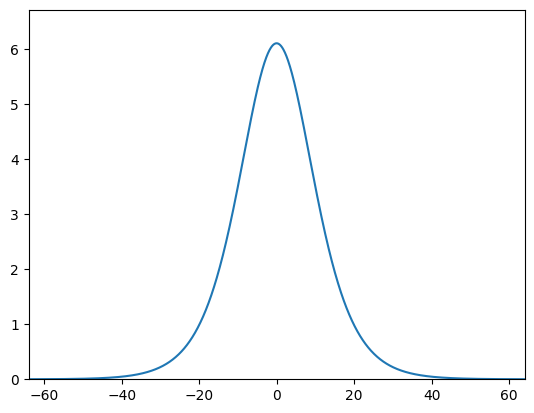

In [19]:
def getPower(u):
    return np.abs(u)**2

def sechPulse(time, amplitude, duration):
    return amplitude/np.cosh(time/duration)

duration = 2**7*dt
amplitude = np.sqrt(np.abs(beta2)/gamma/duration**2)*10
pulse = sechPulse(t, amplitude, duration)

plt.plot(t*1e12, getPower(pulse))
plt.axis([-duration*5*1e12, duration*5*1e12, 0, 1.1*amplitude**2])

# Initializing Collocation Point

In [22]:
t_new = t[(t>-5*duration) & (t<5*duration)]*1e12

num_train = 1000
num_label = 100
t_f = t_new[-1]
t_init = t_new[0]

x_f = 1000
x_init = 0 

start_point = np.array([t_init, x_init])
final_point = np.array([t_f, x_f])

def sechPulse(time, amplitude, duration):
    time = time/1e12
    return amplitude/np.cosh(time/duration)

duration = 2**7*dt
amplitude = np.sqrt(np.abs(beta2)/gamma/duration**2)*10

In [23]:
gen_data = initData()


#collocation point 
col_point = gen_data.init_points(final_point, start_point, num_train)

#initial condition (x = 0)
init_point = np.zeros((num_label, 2))
init_point[..., 0] = gen_data.init_points(t_f, t_init, num_label).reshape(-1)
init_point[..., 1] = x_init*np.ones_like(init_point[..., 1])

u_init = sechPulse(init_point[..., 0], amplitude, duration) #real part
u_init = np.expand_dims(u_init, axis=1)
v_init = np.zeros_like(u_init) #imaginary part

#lower boundary condition (t = t_init)
lower_point = np.zeros((num_label, 2))
lower_point[..., 0] = t_init*np.ones_like(lower_point[..., 0])
lower_point[..., 1] = gen_data.init_points(x_f, x_init, num_label).reshape(-1)

u_lower = np.zeros_like(lower_point[..., 0])
u_lower = np.expand_dims(u_lower, axis=1)
v_lower = np.zeros_like(u_lower)

#upper boundary condition (t = t_f)
upper_point = np.zeros((num_label, 2))
upper_point[..., 0] = t_f*np.ones_like(upper_point[..., 0])
upper_point[..., 1] = gen_data.init_points(x_f, x_init, num_label).reshape(-1)

u_upper = np.zeros_like(upper_point[..., 0])
u_upper = np.expand_dims(u_upper, axis=1)
v_upper = np.zeros_like(u_upper)




## Initialize and Batch Data

In [24]:
preparation = batchData()
preparation.add_collocation_point(col_point)
preparation.add_labelled_data(init_point, u_init, v_init, 'init_point')
preparation.add_labelled_data(lower_point, u_lower, v_lower, 'bound_lower')
preparation.add_labelled_data(upper_point, u_upper, v_upper, 'bound_upper')

batched_data = preparation.batch_data()
keys = preparation.get_keys()

In [25]:
for key in keys:
    print(f'{key}: {len(batched_data[key])}')

col_point: 10
init_point: 1
bound_lower: 1
bound_upper: 1


# Initializing Model

In [26]:
model = physicsNetwork.build()

# Fit Model

In [ ]:
alpha = .2e-3 
gamma = 10e-3 
beta2 = 100e3*(1e-30)
regularizer_param = 1
optimizer = pinnOptimizer(model, batched_data, alpha, gamma, beta2)
optimizer.fit(1)

In [28]:
T, Z = np.meshgrid(t_new, zlocs)
tZ = np.stack((T.flatten(), Z.flatten()), axis = -1)
result = optimizer.model(tZ).numpy() 

result_u = result[:, 0].reshape(T.shape)
result_v = result[:, 1].reshape(T.shape)

In [29]:
result_P = (result_u**2 + result_v**2)

In [30]:
result_P

array([[1.1162905e-03, 1.1045969e-03, 1.0933046e-03, ..., 4.0731900e-03,
        4.0589324e-03, 4.0453696e-03],
       [3.0671608e+00, 3.0772204e+00, 3.0872986e+00, ..., 4.7062092e-02,
        4.7185041e-02, 4.7308251e-02],
       [1.8989904e-02, 1.8507546e-02, 1.8039906e-02, ..., 2.4027377e-02,
        2.4047896e-02, 2.4068259e-02],
       ...,
       [1.0607351e-05, 1.0607351e-05, 1.0607351e-05, ..., 1.0607351e-05,
        1.0607351e-05, 1.0607351e-05],
       [1.0607351e-05, 1.0607351e-05, 1.0607351e-05, ..., 1.0607351e-05,
        1.0607351e-05, 1.0607351e-05],
       [1.0607351e-05, 1.0607351e-05, 1.0607351e-05, ..., 1.0607351e-05,
        1.0607351e-05, 1.0607351e-05]], dtype=float32)

# Visualize Data

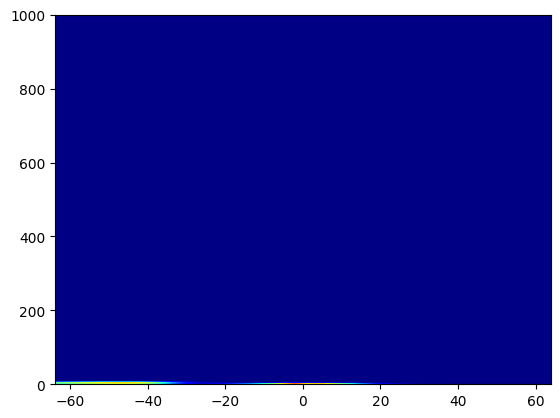

In [31]:
plt.contourf(T, Z, result_P, 100, cmap = 'jet')

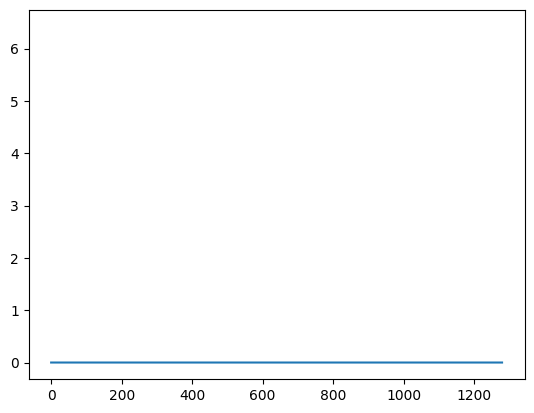

In [43]:
fig, ax = plt.subplots()
line, = ax.plot(result_P[0])

def init():
    line.set_ydata(result_P[0])
    return line,

def update(frame):
    line.set_ydata(result_P[frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames = range(result_P.shape[0]), init_func = init, blit = True)
HTML(ani.to_jshtml())

In [41]:
nrange = 200
cutoff = -30

def plotPulse2D(matrix, t, zlocs, nrange, cutoff):
    fig,ax = plt.subplots()
    ax.set_title('Pulse Evolution (dB scale)')
    thisT = t[int(len(t)/2-nrange):int(len(t)/2+nrange)]*1e12 
    thisZ = zlocs 
    T, Z = np.meshgrid(thisT, thisZ)

    matrix = matrix[:, int(len(t)/2-nrange):int(len(t)/2+nrange)]
    P = matrix/np.max(matrix)

    P[P<1e-100] = 1e-100
    P_dB = 10*np.log10(P)
    P_dB[P_dB<cutoff] = cutoff

    surf = ax.contourf(T,Z,P_dB, levels = 40)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Distance (m)')
    cbar = fig.colorbar(surf, ax = ax)
    plt.show()